<!-- dom:TITLE: Week 45: Random Forests and Boosting -->
# Week 45: Random Forests and Boosting
<!-- dom:AUTHOR: Morten Hjorth-Jensen at Department of Physics, University of Oslo & Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University -->
<!-- Author: -->  
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University

Date: **Nov 3, 2020**

Copyright 1999-2020, Morten Hjorth-Jensen. Released under CC Attribution-NonCommercial 4.0 license



## Overview of week 45

* **Thursday**: Wrapping up from last week. Bagging and Random forests. Boosting methods.

* **Friday**: Boosting and gradient boosting

Geron's chapter 7. See also lecture from [STK-IN4300, lecture 9](https://www.uio.no/studier/emner/matnat/math/STK-IN4300/h20/slides/lecture_9.pdf). Chapter 10 (sections 10.1-10.10 are the most relevant ones)  of Hastie et al contains also a good discussion.

[Video on boosting methods by Hastie (the textbook author)](https://www.youtube.com/watch?v=wPqtzj5VZus&ab_channel=H2O.ai).

## Thursday

Bagging, voting and random forests.
The material on bagging and voting is a repeat from last week and can be found in the slides from week 44.
We repeat here the voting approach since this will serve as a motivation for boosting methods later.

## Why Voting?

The idea behind boosting, and voting as well can be phrased as follows:
**Can a group of people somehow arrive at highly
reasoned decisions, despite the weak judgement of the individual
members?**

The aim is to create a good classifier by combining several weak classifiers.
**A weak classifier is a classifier which is able to produce results that are only slightly better than guessing at random.**

The basic approach is to apply repeatedly (in boosting this is done in an iterative way) a weak classifier to modifications of the data.
In voting we simply apply the law of large numbers while in boosting we give more weight to misclassified data in
each iteration.  

Decision trees play an important role as our weak classifier. They serve as the basic method. 

## Tossing coins

The simplest case is a so-called voting ensemble. To illustrate this,
think of yourself tossing coins with a biased outcome of 51 per cent
for heads and 49% for tails. With only few tosses,
you may not clearly see this distribution for heads and tails. However, after some
thousands of tosses, there will be a clear majority of heads.  With 2000 tosses
you should see approximately 1020 heads and 980 tails.

We can then state that the outcome is a clear majority of heads. If
you do this ten thousand times, it is easy to see that there is a 97%
likelihood of a majority of heads.

Another example would be to collect all polls before an
election. Different polls may show different likelihoods for a
candidate winning with say a majority  of the popular vote. The majority vote
would then consist in many polls indicating that this candidate will
actually win.

The example here shows how we can implement the coin tossing case,
clealry demostrating that after some tosses we see the [law of large](https://en.wikipedia.org/wiki/Law_of_large_numbers)
numbers kicking in.

## Standard imports first

In [1]:
%matplotlib inline

# Common imports
from IPython.display import Image 
from pydot import graph_from_dot_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from IPython.display import Image 
from pydot import graph_from_dot_data
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

## Simple Voting Example, head or tail

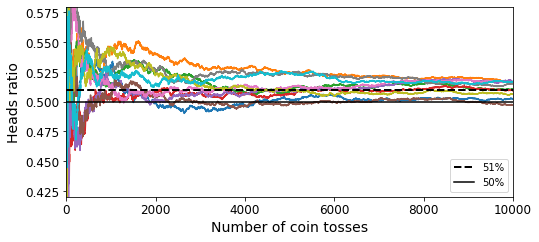

In [2]:

# Common imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("votingsimple")
plt.show()

## Using the Voting Classifier

We can use the voting classifier on other data sets, here the excting binary case of two distinct objects using the make moons functionality of -Scikit-Learn-.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896
LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


## Please, not the moons again! Voting and Bagging

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [6]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## Random forests

Random forests provide an improvement over bagged trees by way of a
small tweak that decorrelates the trees. 

As in bagging, we build a
number of decision trees on bootstrapped training samples. But when
building these decision trees, each time a split in a tree is
considered, a random sample of $m$ predictors is chosen as split
candidates from the full set of $p$ predictors. The split is allowed to
use only one of those $m$ predictors. 

A fresh sample of $m$ predictors is
taken at each split, and typically we choose

$$
m\approx \sqrt{p}.
$$

In building a random forest, at
each split in the tree, the algorithm is not even allowed to consider
a majority of the available predictors. 

The reason for this is rather clever. Suppose that there is one very
strong predictor in the data set, along with a number of other
moderately strong predictors. Then in the collection of bagged
variable importance random forest trees, most or all of the trees will
use this strong predictor in the top split. Consequently, all of the
bagged trees will look quite similar to each other. Hence the
predictions from the bagged trees will be highly correlated.
Unfortunately, averaging many highly correlated quantities does not
lead to as large of a reduction in variance as averaging many
uncorrelated quantities. In particular, this means that bagging will
not lead to a substantial reduction in variance over a single tree in
this setting.


## Random Forest Algorithm
The algorithm described here can be applied to both classification and regression problems.

We will grow of forest of say $B$ trees.
1. For $b=1:B$

  * Draw a bootstrap sample of from the training data organized in our $\boldsymbol{X}$ matrix.

  * We grow then a random forest tree $T_b$ based on the bootstrapped data by repeating the steps outlined till we reach the maximum node size is reached

1. we select $m \le p$ variables at random from the $p$ predictors/features

2. pick the best split point among the $m$ features using either the CART algorithm or the ID3 for classification and create a new node

3. split the node into daughter nodes



4. Output then the ensemble of trees $\{T_b\}_1^{B}$ and make predictions for either a regression type of problem or a classification type of problem. 

## Random Forests Compared with other Methods on the Cancer Data

(426, 30)
(143, 30)
Test set accuracy with Logistic Regression: 0.95
Test set accuracy with SVM: 0.63
Test set accuracy with Decision Trees: 0.87
Test set accuracy Logistic Regression with scaled data: 0.96
Test set accuracy SVM with scaled data: 0.96
Test set accuracy with Decision Trees and scaled data: 0.91


/Users/hjensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[1.         0.73333333 0.93333333 1.         1.         0.92857143
 1.         0.92857143 0.92857143 0.92857143]
Test set accuracy with Random Forests and scaled data: 0.98


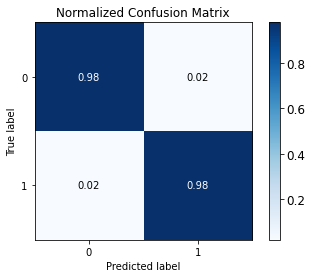

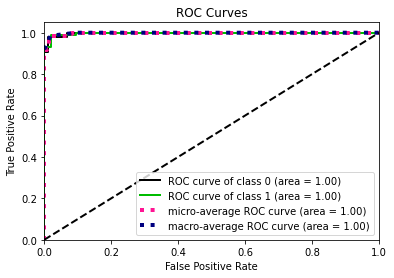

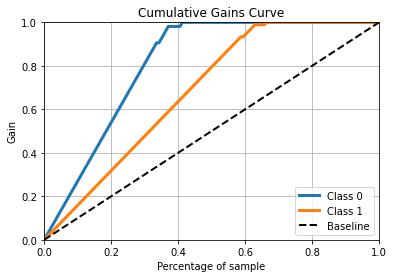

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))
# Support vector machine
svm = SVC(gamma='auto', C=100)
svm.fit(X_train, y_train)
print("Test set accuracy with SVM: {:.2f}".format(svm.score(X_test,y_test)))
# Decision Trees
deep_tree_clf = DecisionTreeClassifier(max_depth=None)
deep_tree_clf.fit(X_train, y_train)
print("Test set accuracy with Decision Trees: {:.2f}".format(deep_tree_clf.score(X_test,y_test)))
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Logistic Regression
logreg.fit(X_train_scaled, y_train)
print("Test set accuracy Logistic Regression with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))
# Support Vector Machine
svm.fit(X_train_scaled, y_train)
print("Test set accuracy SVM with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))
# Decision Trees
deep_tree_clf.fit(X_train_scaled, y_train)
print("Test set accuracy with Decision Trees and scaled data: {:.2f}".format(deep_tree_clf.score(X_test_scaled,y_test)))


from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
# Data set not specificied
#Instantiate the model with 500 trees and entropy as splitting criteria
Random_Forest_model = RandomForestClassifier(n_estimators=500,criterion="entropy")
Random_Forest_model.fit(X_train_scaled, y_train)
#Cross validation
accuracy = cross_validate(Random_Forest_model,X_test_scaled,y_test,cv=10)['test_score']
print(accuracy)
print("Test set accuracy with Random Forests and scaled data: {:.2f}".format(Random_Forest_model.score(X_test_scaled,y_test)))


import scikitplot as skplt
y_pred = Random_Forest_model.predict(X_test_scaled)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()
y_probas = Random_Forest_model.predict_proba(X_test_scaled)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
plt.show()

## Compare  Bagging on Trees with Random Forests

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [10]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.9790209790209791

## Boosting, a Bird's Eye View

The basic idea is to combine weak classifiers in order to create a good
classifier. With a weak classifier we often intend a classifier which
produces results which are only slightly better than we would get by
random guesses.

This is done by applying in an iterative way a weak (or a standard
classifier like decision trees) to modify the data. In each iteration
we emphasize those observations which are misclassified by weighting
them with a factor.


## What is boosting? Additive Modelling/Iterative Fitting

Boosting is a way of fitting an additive expansion in a set of
elementary basis functions like for example some simple polynomials.
Assume for example that we have a function

$$
f_M(x) = \sum_{i=1}^M \beta_m b(x;\gamma_m),
$$

where $\beta_m$ are the expansion parameters to be determined in a
minimization process and $b(x;\gamma_m)$ are some simple functions of
the multivariable parameter $x$ which is characterized by the
parameters $\gamma_m$.

As an example, consider the Sigmoid function we used in logistic
regression. In that case, we can translate the function
$b(x;\gamma_m)$ into the Sigmoid function

$$
\sigma(t) = \frac{1}{1+\exp{(-t)}},
$$

where $t=\gamma_0+\gamma_1 x$ and the parameters $\gamma_0$ and
$\gamma_1$ were determined by the Logistic Regression fitting
algorithm.

As another example, consider the cost function we defined for linear regression

$$
C(\boldsymbol{y},\boldsymbol{f}) = \frac{1}{n} \sum_{i=0}^{n-1}(y_i-f(x_i))^2.
$$

In this case the function $f(x)$ was replaced by the design matrix
$\boldsymbol{X}$ and the unknown linear regression parameters $\boldsymbol{\beta}$,
that is $\boldsymbol{f}=\boldsymbol{X}\boldsymbol{\beta}$. In linear regression we can 
simply invert a matrix and obtain the parameters $\beta$ by

$$
\boldsymbol{\beta}=\left(\boldsymbol{X}^T\boldsymbol{X}\right)^{-1}\boldsymbol{X}^T\boldsymbol{y}.
$$

In iterative fitting or additive modeling, we minimize the cost function with respect to the parameters $\beta_m$ and $\gamma_m$.


## Iterative Fitting, Regression and Squared-error Cost Function

The way we proceed is as follows (here we specialize to the squared-error cost function)

1. Establish a cost function, here ${\cal C}(\boldsymbol{y},\boldsymbol{f}) = \frac{1}{n} \sum_{i=0}^{n-1}(y_i-f_M(x_i))^2$ with $f_M(x) = \sum_{i=1}^M \beta_m b(x;\gamma_m)$.

2. Initialize with a guess $f_0(x)$. It could be one or even zero or some random numbers.

3. For $m=1:M$

a. minimize $\sum_{i=0}^{n-1}(y_i-f_{m-1}(x_i)-\beta b(x;\gamma))^2$ wrt $\gamma$ and $\beta$

b. This gives the optimal values $\beta_m$ and $\gamma_m$

c. Determine then the new values $f_m(x)=f_{m-1}(x) +\beta_m b(x;\gamma_m)$


We could use any of the algorithms we have discussed till now. If we
use trees, $\gamma$ parameterizes the split variables and split points
at the internal nodes, and the predictions at the terminal nodes.


## Squared-Error Example and Iterative Fitting

To better understand what happens, let us develop the steps for the iterative fitting using the above squared error function.

For simplicity we assume also that our functions $b(x;\gamma)=1+\gamma x$. 

This means that for every iteration $m$, we need to optimize

$$
(\beta_m,\gamma_m) = \mathrm{argmin}_{\beta,\lambda}\hspace{0.1cm} \sum_{i=0}^{n-1}(y_i-f_{m-1}(x_i)-\beta b(x;\gamma))^2=\sum_{i=0}^{n-1}(y_i-f_{m-1}(x_i)-\beta(1+\gamma x_i))^2.
$$

We start our iteration by simply setting $f_0(x)=0$. 
Taking the derivatives  with respect to $\beta$ and $\gamma$ we obtain

$$
\frac{\partial {\cal C}}{\partial \beta} = -2\sum_{i}(1+\gamma x_i)(y_i-\beta(1+\gamma x_i))=0,
$$

and

$$
\frac{\partial {\cal C}}{\partial \gamma} =-2\sum_{i}\beta x_i(y_i-\beta(1+\gamma x_i))=0.
$$

We can then rewrite these equations as (defining $\boldsymbol{w}=\boldsymbol{e}+\gamma \boldsymbol{x})$ with $\boldsymbol{e}$ being the unit vector)

$$
\gamma \boldsymbol{w}^T(\boldsymbol{y}-\beta\gamma \boldsymbol{w})=0,
$$

which gives us $\beta = \boldsymbol{w}^T\boldsymbol{y}/(\boldsymbol{w}^T\boldsymbol{w})$. Similarly we have

$$
\beta\gamma \boldsymbol{x}^T(\boldsymbol{y}-\beta(1+\gamma \boldsymbol{x}))=0,
$$

which leads to $\gamma =(\boldsymbol{x}^T\boldsymbol{y}-\beta\boldsymbol{x}^T\boldsymbol{e})/(\beta\boldsymbol{x}^T\boldsymbol{x})$.  Inserting
for $\beta$ gives us an equation for $\gamma$. This is a non-linear equation in the unknown $\gamma$ and has to be solved numerically. 

The solution to these two equations gives us in turn $\beta_1$ and $\gamma_1$ leading to the new expression for $f_1(x)$ as
$f_1(x) = \beta_1(1+\gamma_1x)$. Doing this $M$ times results in our final estimate for the function $f$. 



## Iterative Fitting, Classification and AdaBoost

Let us consider a binary classification problem with two outcomes $y_i \in \{-1,1\}$ and $i=0,1,2,\dots,n-1$ as our set of
observations. We define a classification function $G(x)$ which produces a prediction taking one or the other of the two values 
$\{-1,1\}$.

The error rate of the training sample is then

$$
\mathrm{\overline{err}}=\frac{1}{n} \sum_{i=0}^{n-1} I(y_i\ne G(x_i)).
$$

The iterative procedure starts with defining a weak classifier whose
error rate is barely better than random guessing.  The iterative
procedure in boosting is to sequentially apply a  weak
classification algorithm to repeatedly modified versions of the data
producing a sequence of weak classifiers $G_m(x)$.

Here we will express our  function $f(x)$ in terms of $G(x)$. That is

$$
f_M(x) = \sum_{i=1}^M \beta_m b(x;\gamma_m),
$$

will be a function of

$$
G_M(x) = \mathrm{sign} \sum_{i=1}^M \alpha_m G_m(x).
$$

## Adaptive Boosting, AdaBoost

In our iterative procedure we define thus

$$
f_m(x) = f_{m-1}(x)+\beta_mG_m(x).
$$

The simplest possible cost function which leads (also simple from a computational point of view) to the AdaBoost algorithm is the
exponential cost/loss function defined as

$$
C(\boldsymbol{y},\boldsymbol{f}) = \sum_{i=0}^{n-1}\exp{(-y_i(f_{m-1}(x_i)+\beta G(x_i))}.
$$

We optimize $\beta$ and $G$ for each value of $m=1:M$ as we did in the regression case.
This is normally done in two steps. Let us however first rewrite the cost function as

$$
C(\boldsymbol{y},\boldsymbol{f}) = \sum_{i=0}^{n-1}w_i^{m}\exp{(-y_i\beta G(x_i))},
$$

where we have defined $w_i^m= \exp{(-y_if_{m-1}(x_i))}$.

## Building up AdaBoost

First, for any $\beta > 0$, we optimize $G$ by setting

$$
G_m(x) = \mathrm{sign} \sum_{i=0}^{n-1} w_i^m I(y_i \ne G_(x_i)),
$$

which is the classifier that minimizes the weighted error rate in predicting $y$.

We can do this by rewriting

$$
\exp{-(\beta)}\sum_{y_i=G(x_i)}w_i^m+\exp{(\beta)}\sum_{y_i\ne G(x_i)}w_i^m,
$$

which can be rewritten as

$$
(\exp{(\beta)}-\exp{-(\beta)})\sum_{i=0}^{n-1}w_i^mI(y_i\ne G(x_i))+\exp{(-\beta)}\sum_{i=0}^{n-1}w_i^m=0,
$$

which leads to

$$
\beta_m = \frac{1}{2}\log{\frac{1-\mathrm{\overline{err}}}{\mathrm{\overline{err}}}},
$$

where we have redefined the error as

$$
\mathrm{\overline{err}}_m=\frac{1}{n}\frac{\sum_{i=0}^{n-1}w_i^mI(y_i\ne G(x_i)}{\sum_{i=0}^{n-1}w_i^m},
$$

which leads to an update of

$$
f_m(x) = f_{m-1}(x) +\beta_m G_m(x).
$$

This leads to the new weights

$$
w_i^{m+1} = w_i^m \exp{(-y_i\beta_m G_m(x_i))}
$$

## Adaptive boosting: AdaBoost, Basic Algorithm

The algorithm here is rather straightforward. Assume that our weak
classifier is a decision tree and we consider a binary set of outputs
with $y_i \in \{-1,1\}$ and $i=0,1,2,\dots,n-1$ as our set of
observations. Our design matrix is given in terms of the
feature/predictor vectors
$\boldsymbol{X}=[\boldsymbol{x}_0\boldsymbol{x}_1\dots\boldsymbol{x}_{p-1}]$. Finally, we define also a
classifier determined by our data via a function $G(x)$. This function tells us how well we are able to classify our outputs/targets $\boldsymbol{y}$. 

We have already defined the misclassification error $\mathrm{err}$ as

$$
\mathrm{err}=\frac{1}{n}\sum_{i=0}^{n-1}I(y_i\ne G(x_i)),
$$

where the function $I()$ is one if we misclassify and zero if we classify correctly. 

## Basic Steps of AdaBoost

With the above definitions we are now ready to set up the algorithm for AdaBoost.
The basic idea is to set up weights which will be used to scale the correctly classified and the misclassified cases.
1. We start by initializing all weights to $w_i = 1/n$, with $i=0,1,2,\dots n-1$. It is easy to see that we must have $\sum_{i=0}^{n-1}w_i = 1$.

2. We rewrite the misclassification error as

$$
\mathrm{\overline{err}}_m=\frac{\sum_{i=0}^{n-1}w_i^m I(y_i\ne G(x_i))}{\sum_{i=0}^{n-1}w_i},
$$

1. Then we start looping over all attempts at classifying, namely we start an iterative process for $m=1:M$, where $M$ is the final number of classifications. Our given classifier could for example be a plain decision tree.

a. Fit then a given classifier to the training set using the weights $w_i$.

b. Compute then $\mathrm{err}$ and figure out which events are classified properly and which are classified wrongly.

c. Define a quantity $\alpha_{m} = \log{(1-\mathrm{\overline{err}}_m)/\mathrm{\overline{err}}_m}$

d. Set the new weights to $w_i = w_i\times \exp{(\alpha_m I(y_i\ne G(x_i)}$.


5. Compute the new classifier $G(x)= \sum_{i=0}^{n-1}\alpha_m I(y_i\ne G(x_i)$.

For the iterations with $m \le 2$ the weights are modified
individually at each steps. The observations which were misclassified
at iteration $m-1$ have a weight which is larger than those which were
classified properly. As this proceeds, the observations which were
difficult to classifiy correctly are given a larger influence. Each
new classification step $m$ is then forced to concentrate on those
observations that are missed in the previous iterations.



## AdaBoost Examples

Using **Scikit-Learn** it is easy to apply the adaptive boosting algorithm, as done here.

In [11]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train_scaled, y_train)
y_pred = ada_clf.predict(X_test_scaled)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()
y_probas = ada_clf.predict_proba(X_test_scaled)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
plt.show()

## AdaBoost for Regression

Here we present [Drucker's AdaBoost](https://pdfs.semanticscholar.org/8d49/e2dedb817f2c3330e74b63c5fc86d2399ce3.pdf) tailored for regression.

In bagging, each training example is equally likely to be
picked. In boosting, the probability of a particular
example being in the training set of a particular machine
depends on the performance of the prior machines on
that example. The following is a modification of
Adaboost by Drucker.

Start by selecting a set of training data $n$ and assign to each entry a weight $w_i=1$ for $i=1,2,\dots,n$. As we have done earlier, we could pick say $80\%$ of the data set for training. The algorithm runs as follows:
1. We define the probability that the  training sample $i$ is in the set by $p_i = w_i/\sum_iw_i$. We pick $n$ samples (with replacement) to form our training set. We pick a number uniformly in the range $[0,\sum_iw_i]$.

2. We choose then a regression machine (for example plain linear regression or a simple decision tree). A given regression machine makes then a hypothesis.

3. Using every member of the training set with the chosen regression machine we obtain then a prediction $\tilde{y}_i$.

4. We calculate then the loss function $L_i$ for each training sample. We can use various types of loss function as long as we have a value

$L_i\in [0,1]$. 

## Gradient boosting: Basics with Steepest Descent

Gradient boosting is again a similar technique to Adaptive boosting,
it combines so-called weak classifiers or regressors into a strong
method via a series of iterations.

In order to understand the method, let us illustrate its basics by
bringing back the essential steps in linear regression, where our cost
function was the least squares function.

## The Squared-Error again! Steepest Descent

We start again with our cost function ${\cal C}(\boldsymbol{y}m\boldsymbol{f})=\sum_{i=0}^{n-1}{\cal L}(y_i, f(x_i))$ where we want to minimize
This means that for every iteration, we need to optimize

$$
(\hat{\boldsymbol{f}}) = \mathrm{argmin}_{\boldsymbol{f}}\hspace{0.1cm} \sum_{i=0}^{n-1}(y_i-f(x_i))^2.
$$

We define a real function $h_m(x)$ that defines our final function $f_M(x)$ as

$$
f_M(x) = \sum_{m=0}^M h_m(x).
$$

In the steepest decent approach we approximate $h_m(x) = -\rho_m g_m(x)$, where $\rho_m$ is a scalar and $g_m(x)$ the gradient defined as

$$
g_m(x_i) = \left[ \frac{\partial {\cal L}(y_i, f(x_i))}{\partial f(x_i)}\right]_{f(x_i)=f_{m-1}(x_i)}.
$$

With the new gradient we can update $f_m(x) = f_{m-1}(x) -\rho_m g_m(x)$. Using the above squared-error function we see that
the gradient is $g_m(x_i) = -2(y_i-f(x_i))$.

Choosing $f_0(x)=0$ we obtain $g_m(x) = -2y_i$ and inserting this into the minimization problem for the cost function we have

$$
(\rho_1) = \mathrm{argmin}_{\rho}\hspace{0.1cm} \sum_{i=0}^{n-1}(y_i+2\rho y_i)^2.
$$

## Steepest Descent Example

Optimizing with respect to $\rho$ we obtain (taking the derivative) that $\rho_1 = -1/2$. We have then that

$$
f_1(x) = f_{0}(x) -\rho_1 g_1(x)=-y_i.
$$

We can then proceed and compute

$$
g_2(x_i) = \left[ \frac{\partial {\cal L}(y_i, f(x_i))}{\partial f(x_i)}\right]_{f(x_i)=f_{1}(x_i)=y_i}=-4y_i,
$$

and find a new value for $\rho_2=-1/2$ and continue till we have reached $m=M$. We can modify the steepest descent method, or steepest boosting, by introducing what is called **gradient boosting**. 

## Gradient Boosting, algorithm

Suppose we have a cost function $C(f)=\sum_{i=0}^{n-1}L(y_i, f(x_i))$ where $y_i$ is our target and $f(x_i)$ the function which is meant to model $y_i$. The above cost function could be our standard  squared-error  function

$$
C(\boldsymbol{y},\boldsymbol{f})=\sum_{i=0}^{n-1}(y_i-f(x_i))^2.
$$

The way we proceed in an iterative fashion is to
1. Initialize our estimate $f_0(x)$.

2. For $m=1:M$, we

a. compute the negative gradient vector $\boldsymbol{u}_m = -\partial C(\boldsymbol{y},\boldsymbol{f})/\partial \boldsymbol{f}(x)$ at $f(x) = f_{m-1}(x)$;

b. fit the so-called base-learner to the negative gradient $h_m(u_m,x)$;

c. update the estimate $f_m(x) = f_{m-1}(x)+\nu h_m(u_m,x)$;


4. The final estimate is then $f_M(x) = \sum_{m=1}^M\nu h_m(u_m,x)$.

## Gradient Boosting Example, Regression

We discuss here the difference between the steepest descent approach and gradient boosting by repeating our simple regression example above. 


## Gradient Boosting, Examples of Regression

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import scikitplot as skplt
from sklearn.metrics import mean_squared_error

n = 100
maxdegree = 6

# Make data set.
x = np.linspace(-3, 3, n).reshape(-1, 1)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, x.shape)

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

for degree in range(1,maxdegree):
    model = GradientBoostingRegressor(max_depth=degree, n_estimators=100, learning_rate=1.0)  
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((y_test - y_pred)**2) )
    bias[degree] = np.mean( (y_test - np.mean(y_pred))**2 )
    variance[degree] = np.mean( np.var(y_pred) )
    print('Max depth:', degree)
    print('Error:', error[degree])
    print('Bias^2:', bias[degree])
    print('Var:', variance[degree])
    print('{} >= {} + {} = {}'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

plt.xlim(1,maxdegree-1)
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.legend()
save_fig("gdregression")
plt.show()

## Gradient Boosting, Classification Example

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
import scikitplot as skplt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

gd_clf = GradientBoostingClassifier(max_depth=3, n_estimators=100, learning_rate=1.0)  
gd_clf.fit(X_train_scaled, y_train)
#Cross validation
accuracy = cross_validate(gd_clf,X_test_scaled,y_test,cv=10)['test_score']
print(accuracy)
print("Test set accuracy with Random Forests and scaled data: {:.2f}".format(gd_clf.score(X_test_scaled,y_test)))

import scikitplot as skplt
y_pred = gd_clf.predict(X_test_scaled)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
save_fig("gdclassiffierconfusion")
plt.show()
y_probas = gd_clf.predict_proba(X_test_scaled)
skplt.metrics.plot_roc(y_test, y_probas)
save_fig("gdclassiffierroc")
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
save_fig("gdclassiffiercgain")
plt.show()

## XGBoost: Extreme Gradient Boosting


[XGBoost](https://github.com/dmlc/xgboost) or Extreme Gradient
Boosting, is an optimized distributed gradient boosting library
designed to be highly efficient, flexible and portable. It implements
machine learning algorithms under the Gradient Boosting
framework. XGBoost provides a parallel tree boosting that solve many
data science problems in a fast and accurate way. See the [article by Chen and Guestrin](https://arxiv.org/abs/1603.02754).

The authors design and build a highly scalable end-to-end tree
boosting system. It has  a theoretically justified weighted quantile
sketch for efficient proposal calculation. It introduces a novel sparsity-aware algorithm for parallel tree learning and an effective cache-aware block structure for out-of-core tree learning.

It is now the algorithm which wins essentially all ML competitions!!!

## Regression Case

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import scikitplot as skplt
from sklearn.metrics import mean_squared_error

n = 100
maxdegree = 6

# Make data set.
x = np.linspace(-3, 3, n).reshape(-1, 1)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, x.shape)

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

for degree in range(maxdegree):
    model =  xgb.XGBRegressor(objective ='reg:squarederror', colsaobjective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = degree, alpha = 10, n_estimators = 200)

    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((y_test - y_pred)**2) )
    bias[degree] = np.mean( (y_test - np.mean(y_pred))**2 )
    variance[degree] = np.mean( np.var(y_pred) )
    print('Max depth:', degree)
    print('Error:', error[degree])
    print('Bias^2:', bias[degree])
    print('Var:', variance[degree])
    print('{} >= {} + {} = {}'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

plt.xlim(1,maxdegree-1)
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.legend()
plt.show()

## Xgboost on the Cancer Data

As you will see from the confusion matrix below, XGBoots does an excellent job on the Wisconsin cancer data and outperforms essentially all agorithms we have discussed till now.

In [15]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
import scikitplot as skplt
import xgboost as xgb
# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

xg_clf = xgb.XGBClassifier()
xg_clf.fit(X_train_scaled,y_train)

y_test = xg_clf.predict(X_test_scaled)

print("Test set accuracy with Random Forests and scaled data: {:.2f}".format(xg_clf.score(X_test_scaled,y_test)))

import scikitplot as skplt
y_pred = xg_clf.predict(X_test_scaled)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
save_fig("xdclassiffierconfusion")
plt.show()
y_probas = xg_clf.predict_proba(X_test_scaled)
skplt.metrics.plot_roc(y_test, y_probas)
save_fig("xdclassiffierroc")
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
save_fig("gdclassiffiercgain")
plt.show()


xgb.plot_tree(xg_clf,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
save_fig("xgtree")
plt.show()

xgb.plot_importance(xg_clf)
plt.rcParams['figure.figsize'] = [5, 5]
save_fig("xgparams")
plt.show()